In [1]:
%matplotlib inline
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)
from glob import glob

Using TensorFlow backend.


In [2]:
cfg = local_import("./laptop.py")

In [ ]:
conn = sqlite3.connect(cfg.posts_path)

In [3]:
allmetas = sorted(glob(os.path.join(cfg.paths["metas"], "posts_*.hdf5")))
print allmetas

['/home/alex/data/stackexchange/overflow/caches/posts_2008.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2009.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2010.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2011.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2012.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2013.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2014.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2015.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2016.hdf5', '/home/alex/data/stackexchange/overflow/caches/posts_2017.hdf5']


## Histograms of scores and normalized scores for different years

In [23]:
years = []
allhists = []
allhists_normed = []
allhists_normed_2 = []
allhists_normed_views = []
allqs = []

probs = np.asfarray([0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95])

for meta_path in allmetas:
    
    scores = []
    dtyears = []
    viewcounts = []
    
    print meta_path
    year = int(re.findall("\d{4}", meta_path)[0])
    
    store_meta = pd.HDFStore(meta_path, "r", complib="blosc", complevel=9)
    smask = store_meta.select_as_coordinates("posts", "PostTypeId == 1")
    chunks = store_meta.select("posts", chunksize=100000, iterator=True, where=smask, columns=["Id", "CreationDate", "Score", "ViewCount"])
    for chunk in chunks:
        cdate = pd.to_datetime(chunk.CreationDate, origin="julian", unit="D")
#         print chunk.Score.min()
#         print chunk.Score.max()
        enddump = pd.to_datetime("27/08/2017")
        dt_created = enddump - cdate
        dt_created_years = dt_created.dt.total_seconds() * 1. / 3600 / 24 / 365.25
        scores.extend(list(chunk.Score.values))
        dtyears.extend(list(dt_created_years.values))
        viewcounts.extend(list(chunk.ViewCount))
    scores = np.asfarray(scores)
    dtyears = np.asfarray(dtyears)
    viewcounts = np.asfarray(viewcounts)
    
    years.append(year)
    allqs.append(mquantiles(scores, prob=probs))
    allhists.append(np.histogram(scores, range=[-20.5, 2000.5], bins=2021, density=True))
    allhists_normed.append(np.histogram(scores / np.maximum(1.0, dtyears), range=[-20.5, 200], bins=100, density=True))
    allhists_normed_2.append(np.histogram(scores / np.maximum(1.0, dtyears) ** 2.0, range=[-20.5, 200], bins=100, density=True))
    allhists_normed_views.append(np.histogram(scores / viewcounts, range=[-0.2, 0.5], bins=100, density=True))

/home/alex/data/stackexchange/overflow/caches/posts_2008.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2009.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2010.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2011.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2012.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2013.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2014.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2015.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2016.hdf5
/home/alex/data/stackexchange/overflow/caches/posts_2017.hdf5


In [67]:
allhists[0]

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([  -20.5,   -19.5,   -18.5, ...,  1998.5,  1999.5,  2000.5]))

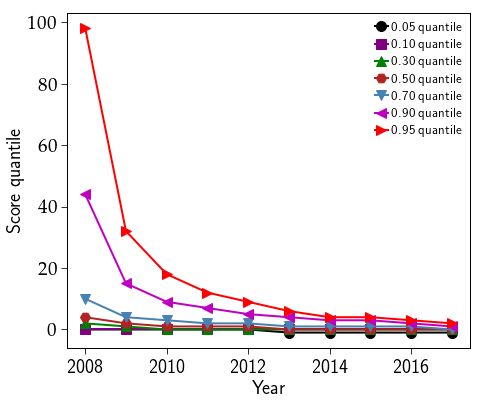

In [50]:
years = np.asfarray(years)

plt.figure(figsize=(8, 6))
plt.xlabel(r"Year")
plt.ylabel(r"Score quantile")

allqs = np.asfarray(allqs)
for iprob, prob in enumerate(probs):
    plt.plot(years, allqs.T[iprob], ls="-", marker=g_markers[iprob],
             color=g_carr[iprob], label=r"%.2f quantile" % prob)

plt.legend(loc="upper right")
plt.gca().xaxis.set_major_formatter(FormatStrFormatter("%i"))
plt.savefig("./plots/score_quantiles_vs_years.pdf")

In [12]:
def GeneralizedGumbelDistribution(x, pars):
    from scipy.special import gamma
    z = (x - pars[0]) / pars[1]
    return 1. / pars[1] * pars[2] ** pars[2] / gamma(pars[2]) * np.e ** (-pars[2] * (z + np.e ** (-z)))

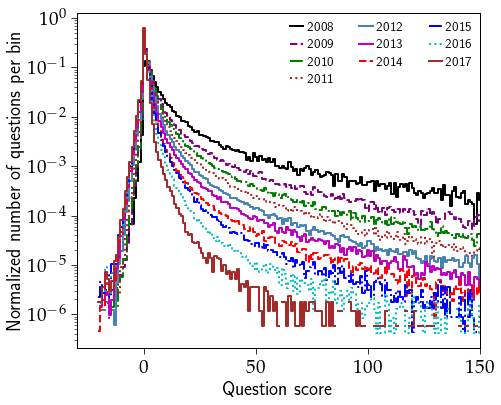

In [46]:
from pyik.mplext import plot_hist
from pyik.numpyext import centers
from pyik.fit import ChiSquareFunction

plt.figure(figsize=(8, 6))
plt.xlabel(r"Question score")
plt.ylabel(r"Normalized number of questions per bin")

for iyear, year in enumerate(years):
    vals, score_edges = allhists[iyear]
    score_cens = centers(score_edges)[0]
#     print score_edges.shape, vals.shape
    plot_hist(score_edges, vals, lw=2, ls=g_ls[iyear], color=g_carr[iyear],
              label="%i" % year)
#     fitfct = lambda x, pars: pars[0] * np.e ** (-np.e ** (-(x - pars[1])/ pars[2]))
#     fitfct = GeneralizedGumbelDistribution
#     chi2fit = ChiSquareFunction(fitfct, score_cens[vals > 0], vals[vals > 0], yerrs=np.sqrt(vals[vals > 0]))
#     chi2fit = ChiSquareFunction(GeneralizedGumbelDistribution, score_cens[vals > 0], vals[vals > 0], yerrs=np.sqrt(vals[vals > 0]))
#     opt, cov, chi2, ndof = chi2fit.Minimize(np.asfarray([0.2, 0, 1]), method="PRAXIS", covarianceMethod = "fast")
#     score_cont = np.linspace(score_edges[0], score_edges[-1], 100)
#     print opt
#     plt.plot(score_cont, fitfct(score_cont, opt), lw=1, ls="-", color=g_carr[iyear])

plt.xlim(-30, 150)
plt.semilogy(nonposy="clip")
plt.legend(loc="upper right", ncol=3)
plt.savefig("./plots/scores_allyears.pdf")

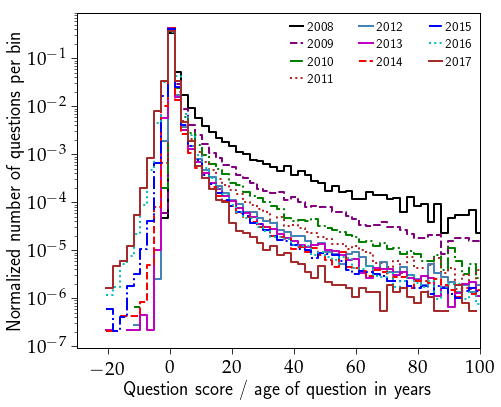

In [47]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Question score / age of question in years")
plt.ylabel(r"Normalized number of questions per bin")

for iyear, year in enumerate(years):
    vals, score_edges = allhists_normed[iyear]
#     print score_edges.shape, vals.shape
    plot_hist(score_edges, vals, lw=2, ls=g_ls[iyear], color=g_carr[iyear],
              label="%i" % year)

plt.xlim(-30, 100)
plt.semilogy(nonposy="clip")
plt.legend(loc="upper right", ncol=3)
plt.savefig("./plots/scores_normed_allyears.pdf")

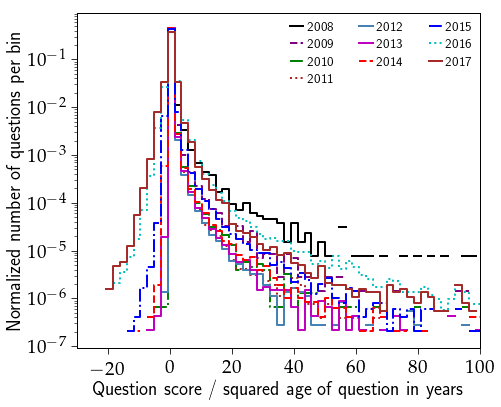

In [48]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Question score / squared age of question in years")
plt.ylabel(r"Normalized number of questions per bin")

for iyear, year in enumerate(years):
    vals, score_edges = allhists_normed_2[iyear]
#     print score_edges.shape, vals.shape
    plot_hist(score_edges, vals, lw=2, ls=g_ls[iyear], color=g_carr[iyear],
              label="%i" % year)

plt.xlim(-30, 100)
plt.semilogy(nonposy="clip")
plt.legend(loc="upper right", ncol=3)
plt.savefig("./plots/scores_normed_allyears_squared.pdf")

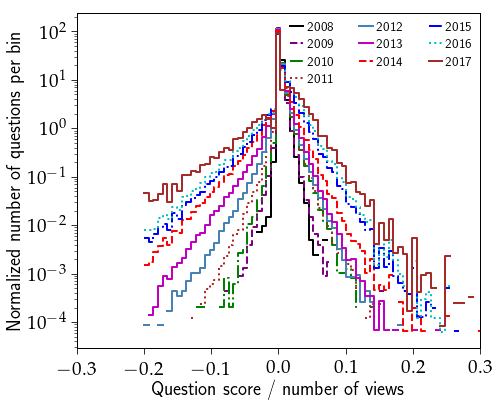

In [49]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Question score / number of views")
plt.ylabel(r"Normalized number of questions per bin")

for iyear, year in enumerate(years):
    vals, score_edges = allhists_normed_views[iyear]
#     print score_edges.shape, vals.shape
    plot_hist(score_edges, vals, lw=2, ls=g_ls[iyear], color=g_carr[iyear],
              label="%i" % year)

plt.xlim(-0.3, 0.3)
plt.semilogy(nonposy="clip")
plt.legend(loc="upper right", ncol=3)
plt.savefig("./plots/scores_normed_viewcount.pdf")

In [ ]:
from gensim.parsing import preprocessing

i = 0
for post in YieldDBPosts(conn):
    print post[0]
    print preprocessing.preprocess_string(post[0])
    i += 1
    if i == 3:
        break